In [54]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")

import math
import numpy as np
import torch as t
import torch.utils.data as tdata
import matplotlib.pyplot as plt
from einops import rearrange

from dots.training import *
from dots.models import MLP
from dots.dots import *
from dots.utils import get_device, plot_dots_stats

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
def linspace(start, end, num):
    x = rearrange(t.linspace(start, end, num), "x -> x 1")
    return x.to(get_device())

# Learning $\sin$

In [14]:
model = MLP(1, 1, hidden = 4, hidden_size = 12)

N = 256
N_test = 64
x = linspace(0, 8, N)
y = t.sin(x)

t.manual_seed(42)
dataset = tdata.TensorDataset(x, y)
train_dataset, test_dataset = tdata.random_split(dataset, lengths = [N - N_test, N_test])
train_dataloader = tdata.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = tdata.DataLoader(test_dataset, batch_size=16, shuffle=True)

n_eps = 5

trainstate = TrainState(
    model=model,
    optimiser=t.optim.Adam(model.parameters(), lr=1e-4),
    loss_fn=t.nn.MSELoss(),
    dataloader=train_dataloader,
    test_loader=test_dataloader,
    hooks=[
        jacobian_rank_hook(linspace(0, 8, 10), epochs=n_eps),
        jacobian_rank_hook(linspace(0, 8, 100), epochs=n_eps),
        jacobian_rank_hook(linspace(0, 8, 1000), epochs=n_eps),
        sv_rank_hook(linspace(0, 8, 100), epochs=n_eps),
        sv_rank_hook(linspace(0, 8, 1000), epochs=n_eps),
        sv_rank_hook(linspace(0, 8, 10), epochs=n_eps)
    ]
)

In [15]:
trainstate.train(1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

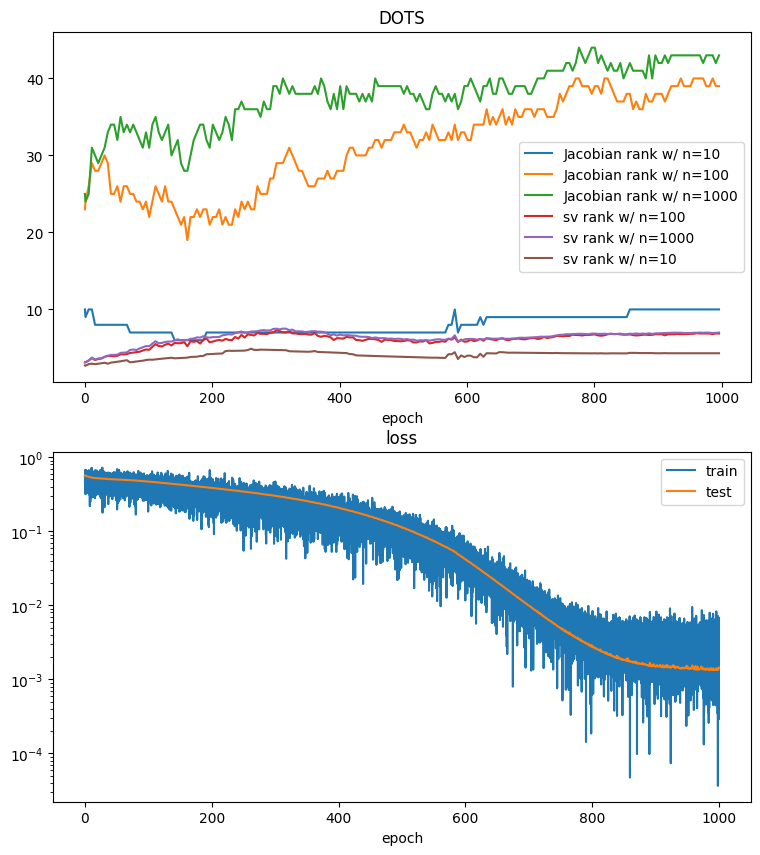

In [16]:
trainstate.plot()

In [17]:
model.count_params()

505

In [18]:
model.jacobian_matrix_rank(linspace(0, 8, 15))

tensor(14)

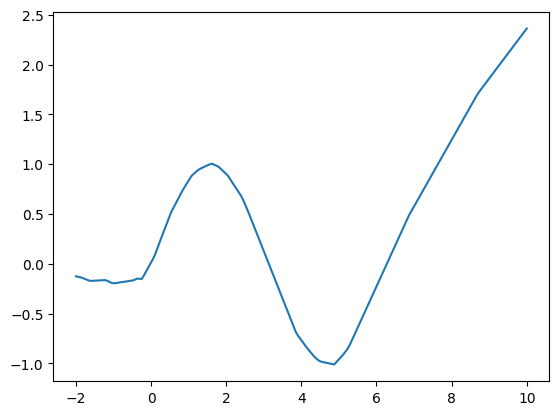

In [19]:
x_ = linspace(-2,10,200).detach()
plt.plot(x_, model(x_).detach())

In [89]:
t.argmax((t.tensor([-3, -2, -1, 0, 1, 2, 3]) > 0).float()).item()

4

In [121]:
model.singular_value_rank(linspace(0,8,1000), method="heuristic")

503

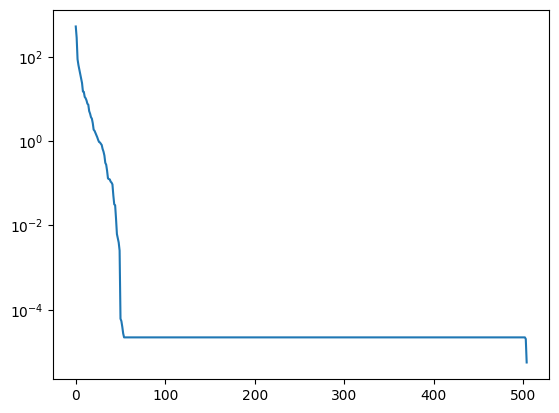

In [120]:
plt.yscale("log")
plt.plot(model.jacobian_singular_values(linspace(0,8,1000)))

Parameters in model: 505


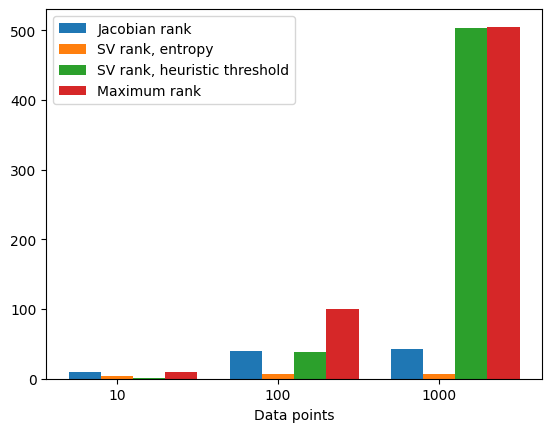

/home/lrudl/Dropbox/Rudolf/Cambridge/22-23/rproj/dots/dots/utils.py:60: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/lrudl/Dropbox/Rudolf/Cambridge/22-23/rproj/dots/dots/utils.py:75: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/lrudl/Dropbox/Rudolf/Cambridge/22-23/rproj/dots/dots/utils.py:84: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


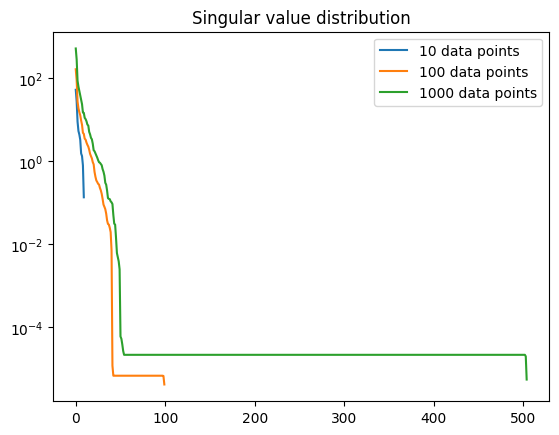

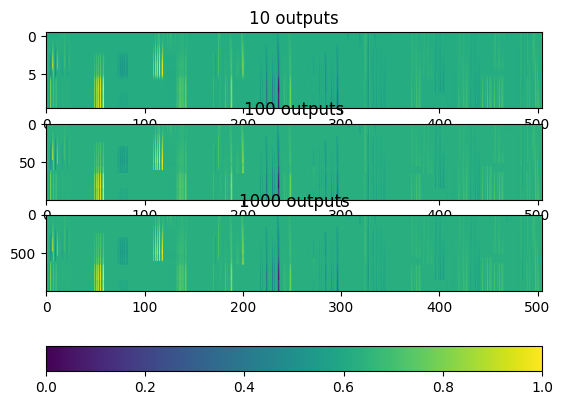

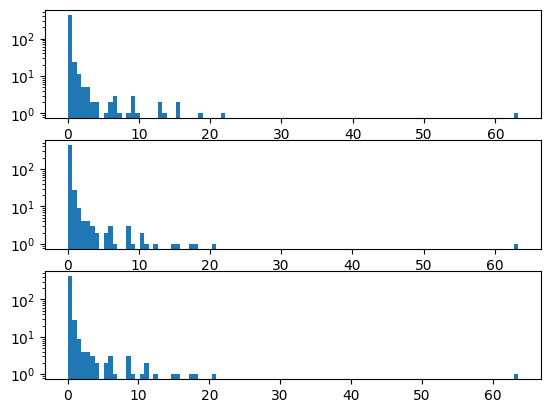

In [119]:
plot_dots_stats(model, [
    linspace(0, 8, 10),
    linspace(0, 8, 100),
    linspace(0, 8, 1000)
])

In [98]:
t.flip(model.jacobian_singular_values(linspace(0, 8, 10)), dims=[0])

tensor([ 0.1362,  0.8019,  1.3374,  1.5449,  3.3109,  4.4051,  5.3748,  8.9997,
        27.7083, 52.7485])

# Learning $\Sigma$

In [20]:
model_s = MLP(4, 1, hidden = 4, hidden_size = 12)

t.manual_seed(42)
N = 1024 + 64
N_test = 64
x = t.rand((N, 4))
x10 = t.rand((10, 4))
x100 = t.rand((100, 4))
x1000 = t.rand((1000, 4))
y = t.sum(x, dim=1, keepdim=True)

dataset = tdata.TensorDataset(x, y)
train_dataset, test_dataset = tdata.random_split(dataset, lengths = [N - N_test, N_test])
train_dataloader = tdata.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = tdata.DataLoader(test_dataset, batch_size=16, shuffle=True)

n_eps = 20

trainstate_s = TrainState(
    model=model_s,
    optimiser=t.optim.Adam(model_s.parameters(), lr=4e-4),
    loss_fn=t.nn.MSELoss(),
    dataloader=train_dataloader,
    test_loader=test_dataloader,
    hooks=[
        jacobian_rank_hook(x10, epochs=n_eps),
        jacobian_rank_hook(x100, epochs=n_eps),
        jacobian_rank_hook(x1000, epochs=n_eps),
        sv_rank_hook(x10, epochs=n_eps),
        sv_rank_hook(x100, epochs=n_eps),
        sv_rank_hook(x1000, epochs=n_eps)
    ]
)

In [21]:
model_s.count_params()

541

In [22]:
trainstate_s.train(200)

  0%|          | 0/200 [00:00<?, ?it/s]

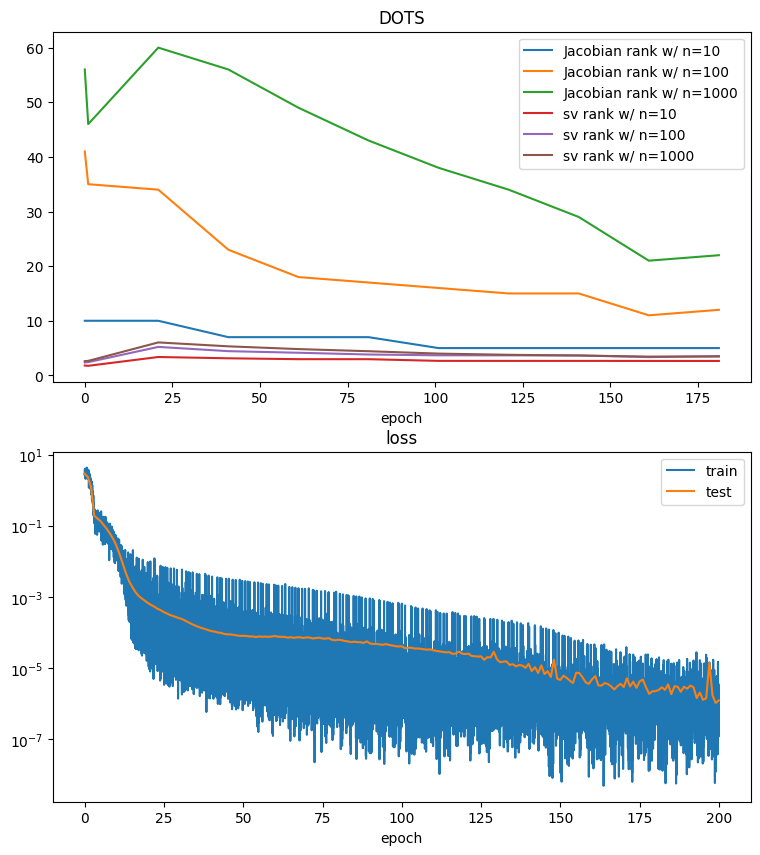

In [23]:
trainstate_s.plot()

In [24]:
model_s(t.tensor([
    [0.1, 0.1, 0.1, 0.1],
    [0.1, 0.0, 0.1, 0.2],
    [0.2, 0.0, 0.1, 0.1]
]))

tensor([[0.3914],
        [0.3979],
        [0.4026]], grad_fn=<AddmmBackward0>)

Parameters in model: 541


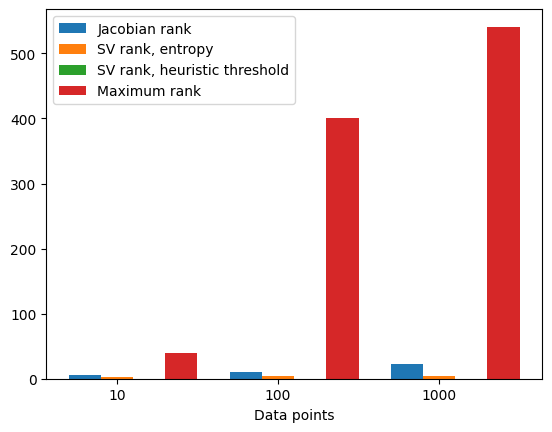

/home/lrudl/Dropbox/Rudolf/Cambridge/22-23/rproj/dots/dots/utils.py:60: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/lrudl/Dropbox/Rudolf/Cambridge/22-23/rproj/dots/dots/utils.py:75: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/lrudl/Dropbox/Rudolf/Cambridge/22-23/rproj/dots/dots/utils.py:84: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


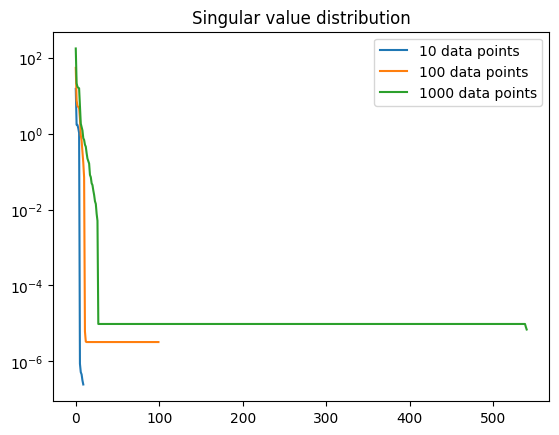

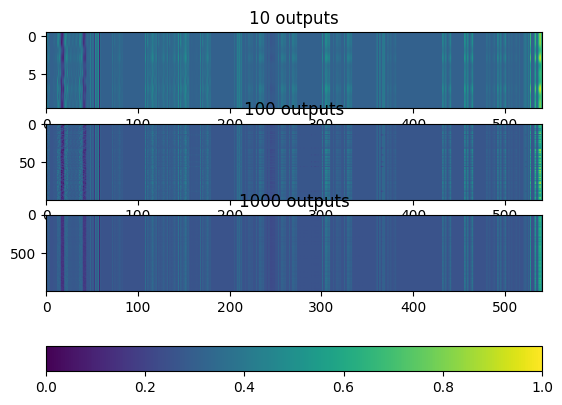

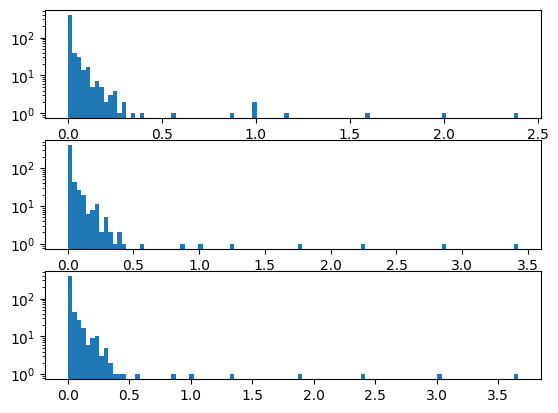

In [122]:
plot_dots_stats(model_s, [
    x10,
    x100,
    x1000
]
)

# Learning MNIST

In [25]:
import torchvision
import torchvision.transforms as transforms

from dots.models import BasicCNN

In [26]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])
mnist = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

100%|██████████| 9912422/9912422 [00:05<00:00, 1939517.17it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 1480206.92it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:01<00:00, 1067133.14it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6382086.69it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [27]:
len(mnist)

60000

In [28]:
mnist

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [29]:
mnist[0][0].shape

torch.Size([1, 28, 28])

In [30]:
train_mnist, test_mnist, valid_mnist = tdata.random_split(
    mnist,
    lengths=[0.8, 0.1, 0.1]
)

In [31]:
mnist_train_loader = tdata.DataLoader(
    train_mnist,
    batch_size=16,
    shuffle=True,
    num_workers=1
)

mnist_test_loader = tdata.DataLoader(
    test_mnist,
    batch_size=16,
    shuffle=True,
    num_workers=1
)

mnist_valid_loader = tdata.DataLoader(
    test_mnist,
    batch_size=16,
    shuffle=True,
    num_workers=1
)

In [32]:
img, lbl = next(iter(mnist_train_loader))
print(img.shape)
print(lbl.shape)

torch.Size([16, 1, 28, 28])
torch.Size([16])


In [33]:
cnn = BasicCNN()

In [34]:
cnn(img).shape

torch.Size([16, 10])

In [35]:
def mnist_data_gen(n):
    return t.randn((n, 1, 28, 28)) / 2 + 0.5

im10 = mnist_data_gen(10)
im100 = mnist_data_gen(100)
im1000 = mnist_data_gen(1000)

In [36]:
cnn.jacobian(im100).shape

torch.Size([100, 10, 2346])

In [37]:
cnn.matrix_jacobian(im100).shape

torch.Size([1000, 2346])

In [38]:
cnn.jacobian_matrix_rank(im100)

tensor(1000)

In [39]:
cnn.singular_value_rank(im100)

tensor(299.1970)

In [79]:
# jacobian_init_ranks = [
#     m.jacobian_matrix_rank(im100).item()
#     for m in [BasicCNN() for _ in range(20)]
# ]

# singular_value_init_ranks = [
#     m.singular_value_rank(im100).item()
#     for m in [BasicCNN() for _ in range(20)]
# ]

In [80]:
# plt.hist([jacobian_init_ranks, singular_value_init_ranks],
#          histtype="barstacked");
# # plt.hist(singular_value_init_ranks)

In [81]:
# plt.hist(singular_value_init_ranks)

In [43]:
n_eps = 1
trainstate_m = TrainState(
    model=cnn,
    optimiser=t.optim.Adam(cnn.parameters(), lr=1e-3),
    loss_fn=t.nn.CrossEntropyLoss(),
    dataloader=mnist_valid_loader,
    test_loader=mnist_test_loader,
    hooks=[
        jacobian_rank_hook(im10, epochs=n_eps),
        jacobian_rank_hook(im100, epochs=n_eps),
        # jacobian_rank_hook(im1000, epochs=n_eps),
        sv_rank_hook(im10, epochs=n_eps),
        sv_rank_hook(im100, epochs=n_eps),
        # sv_rank_hook(im1000, epochs=n_eps)
    ]
)

In [44]:
trainstate_m.train(10)

  0%|          | 0/10 [00:00<?, ?it/s]

In [45]:
cnn.count_params()

2346

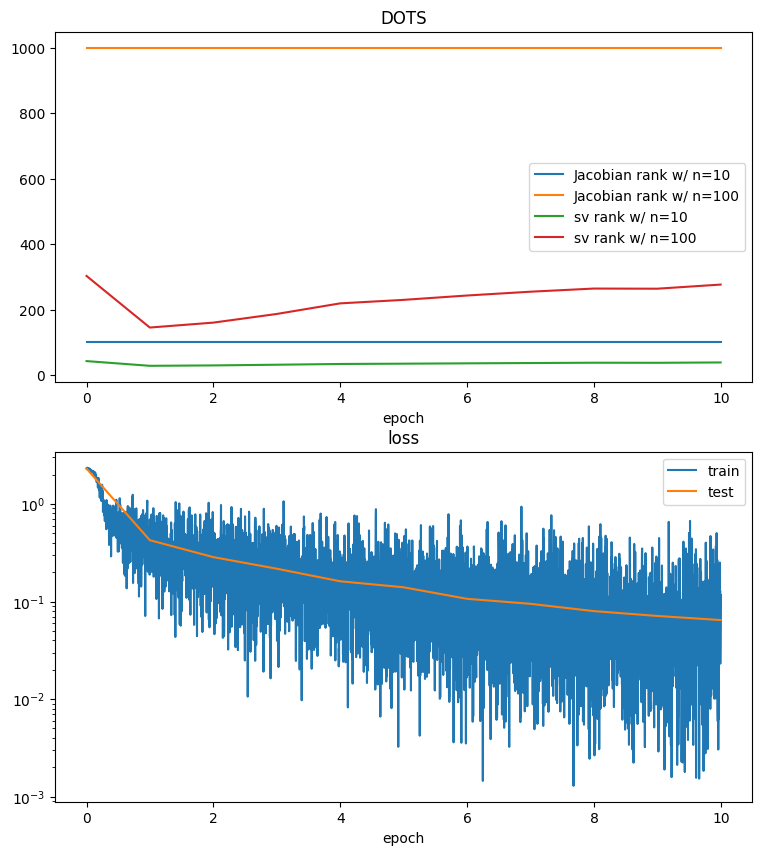

In [46]:
trainstate_m.plot()

In [49]:
trainstate_m.checkpoint()

In [50]:
def mnist_accuracy(model, dl=mnist_test_loader):
    n = 0
    correct = 0
    for batch, label in mnist_test_loader:
        out = model(batch).argmax(dim=-1)
        correct += (out==label).sum()
        n += batch.shape[0]
    return correct / n

In [51]:
mnist_accuracy(cnn)

tensor(0.9813)

Parameters in model: 2346


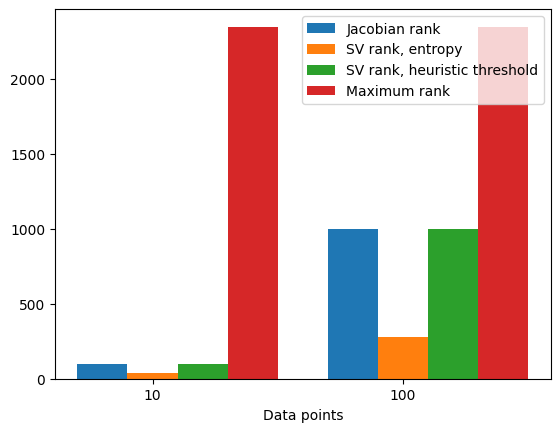

/home/lrudl/Dropbox/Rudolf/Cambridge/22-23/rproj/dots/dots/utils.py:60: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/lrudl/Dropbox/Rudolf/Cambridge/22-23/rproj/dots/dots/utils.py:75: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/lrudl/Dropbox/Rudolf/Cambridge/22-23/rproj/dots/dots/utils.py:84: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


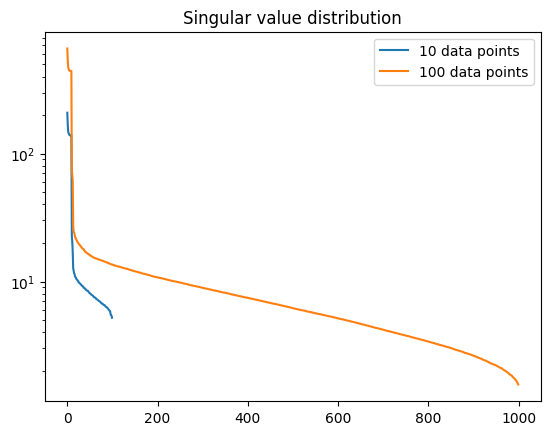

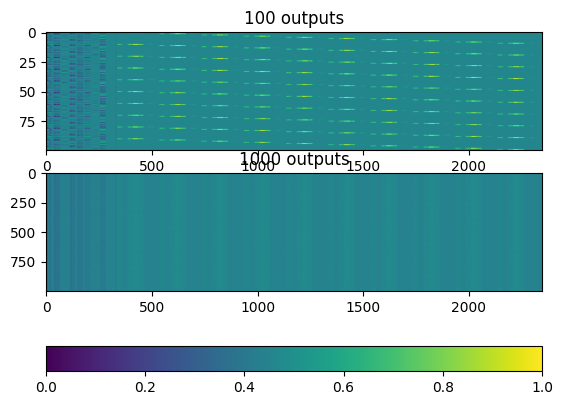

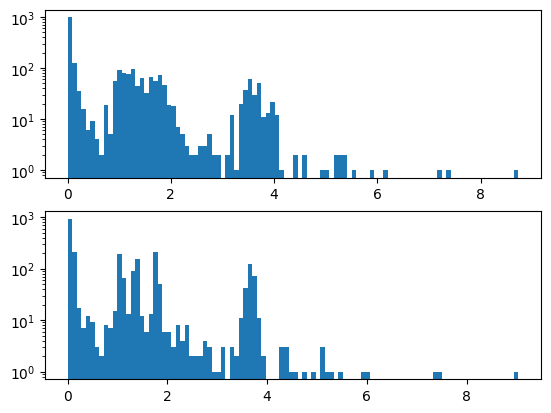

In [123]:
plot_dots_stats(cnn, [im10, im100])